In [13]:
import numpy as np
import xarray as xr
import pickle as pk
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
import scipy.stats as stats
import matplotlib as mpl
mpl.rc('font',size=16,**{'family':'sans-serif','sans-serif':['Arial']})

In [14]:
control = pk.load(open('../Data/Outputs/f.e12.pi-control.T31_g37.ctl.2_diag_grid_int.pk','rb'))
x4 = pk.load(open('../Data/Outputs/f.e12.abrupt-4xCO2.T31_g37.ctl.2_diag_grid_int.pk','rb'))
sol = pk.load(open('../Data/Outputs/f.e12.abrupt-0.96XTSI.T31_g37.ctl.2_diag_grid_int.pk','rb'))

ta_mn = {}
ta_mn['ctl'] = np.nanmean(control['ta_int'],axis=(0,1))
ta_mn['x4'] = np.nanmean(x4['ta_int'],axis=(0,1))
ta_mn['sol'] = np.nanmean(sol['ta_int'],axis=(0,1))

ts_mn = {}
ts_mn['ctl'] = np.nanmean(control['tas'],axis=(0,1))
ts_mn['x4'] = np.nanmean(x4['tas'],axis=(0,1))
ts_mn['sol'] = np.nanmean(sol['tas'],axis=(0,1))

rh_mn = {}
rh_mn['ctl'] = np.nanmean(control['rh_int'],axis=(0,1))
rh_mn['x4'] = np.nanmean(x4['rh_int'],axis=(0,1))
rh_mn['sol'] = np.nanmean(sol['rh_int'],axis=(0,1))


In [15]:
lat = control['lat']
trop_ind = np.where(np.logical_and(lat>=-30, lat<=30))
lon = control['lon']
cmip_plevs = np.asarray([10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000, 1025])

tau = [0.,0.3,1.3,3.6,9.4,23.,60.,380.]
ctp = [1000,800,680,560,440,310,180,50]

y = lat*np.pi/180
coslat = np.cos(y)
coslat_mip = np.tile(coslat[None,:,None],(17,1,lon.size))
coslat_isccp = np.tile(coslat[None,None,None,:,None],(30,7,7,1,lon.size))
trop_weight = np.squeeze(coslat_mip[:,trop_ind,:])

In [16]:
delta = {}
delta['sol'] = {}
delta['x4'] = {}

delta['sol']['rh'] = rh_mn['sol']-rh_mn['ctl']
delta['sol']['ta'] = ta_mn['sol']-ta_mn['ctl']

delta['x4']['rh'] = rh_mn['x4']-rh_mn['ctl']
delta['x4']['ta'] = ta_mn['x4']-ta_mn['ctl']

dtas = {}
dtas['sol'] = ts_mn['sol']-ts_mn['ctl']
dtas['x4'] = ts_mn['x4']-ts_mn['ctl']

In [17]:
delta['x4']['ta'].shape

(17, 48, 96)

In [18]:
delta_trop = {}
dtas_trop = {}
dcld_trop = {}

delta_glob = {}
dtas_glob = {}
dcld_glob = {}
for keys in delta.keys():

    delta_trop[keys] = {}
    delta_glob[keys] = {}

    dtas_trop[keys] = np.average(np.squeeze(dtas[keys][trop_ind,:]),weights=trop_weight[0,:,:])
    dtas_glob[keys] = np.average(dtas[keys],weights=coslat_mip[0,:,:])
    for var in delta[keys].keys():
        delta_trop[keys][var] = np.average(np.squeeze(delta[keys][var][:,trop_ind,:]),weights=(trop_weight),axis=(1,2))
        delta_glob[keys][var] = np.average(delta[keys][var],weights=coslat_mip,axis=(1,2))

In [19]:
append_trop = {}
append_trop['sol'] = np.append(delta_trop['sol']['ta'],dtas_trop['sol'])
append_trop['x4'] = np.append(delta_trop['x4']['ta'],dtas_trop['x4'])

append_glob = {}
append_glob['sol'] = np.append(delta_glob['sol']['ta'],dtas_glob['sol'])
append_glob['x4'] = np.append(delta_glob['x4']['ta'],dtas_glob['x4'])

In [20]:
isccp = {}
isccp['ctl'] = np.nanmean(control['isccp'],axis=1)
isccp['x4'] = np.nanmean(x4['isccp'],axis=1)
isccp['sol'] = np.nanmean(sol['isccp'],axis=1)

delta = {}
delta['x4'] = isccp['x4']-isccp['ctl']
delta['sol'] = isccp['sol']-isccp['ctl']

dgm = {}
dgm['x4'] = np.nanmean(np.average(delta['x4'][:,:,:,:],weights=coslat_isccp[:,:,:,:],axis=(3,4)),axis=0)
dgm['sol'] = np.nanmean(np.average(delta['sol'][:,:,:,:],weights=coslat_isccp[:,:,:,:],axis=(3,4)),axis=0)

In [21]:
sevenb7 = {}
sevenb7_mn = {}

for sim in isccp.keys():
    sevenb7[sim] = np.average(isccp[sim][:,:,:,:],weights=coslat_isccp[:,:,:,:],axis=(3,4))
    sevenb7_mn[sim] = np.nanmean(sevenb7[sim],axis=0)

In [22]:
tval = 2.0017
ttest = {}
pval = {}
ttest['x4'],pval['x4'] = stats.ttest_ind(sevenb7['x4'],sevenb7['ctl'], axis=0,nan_policy='omit')
ttest['sol'],pval['sol'] = stats.ttest_ind(sevenb7['sol'],sevenb7['ctl'], axis=0,nan_policy='omit')

sig = {}
for keys in ttest.keys():
    sig[keys] = (np.abs(ttest[keys]) > tval) & (pval[keys] < 0.05)

binary = {}
for keys in sig.keys():
    binary[keys] = np.zeros([7,7])
    for i in range(7):
        for j in range(7):

            if sig[keys][i,j] == False:
                binary[keys][i,j] = 1
            else:
                pass

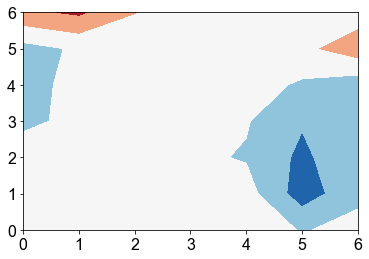

In [23]:
hist_spread = plt.contourf(dgm['x4'],np.arange(-0.25,0.251,0.1),cmap=plt.cm.RdBu_r,extend='both')

/var/folders/cg/kl9yj43d2mvfb7blrzr2thg00000gn/T/ipykernel_43814/2431953730.py:27: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(append_trop['x4'][5:],cmip_plevs[5:],'-o',alpha=0.5,color='red',linestyle='--')
/var/folders/cg/kl9yj43d2mvfb7blrzr2thg00000gn/T/ipykernel_43814/2431953730.py:29: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(append_trop['sol'][5:],cmip_plevs[5:],'-o',alpha=0.5,color='blue',linestyle='--')
/var/folders/cg/kl9yj43d2mvfb7blrzr2thg00000gn/T/ipykernel_43814/2431953730.py:42: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(delta_trop['x4']['rh'][5:],cmip_plevs[5:-1],'-o',

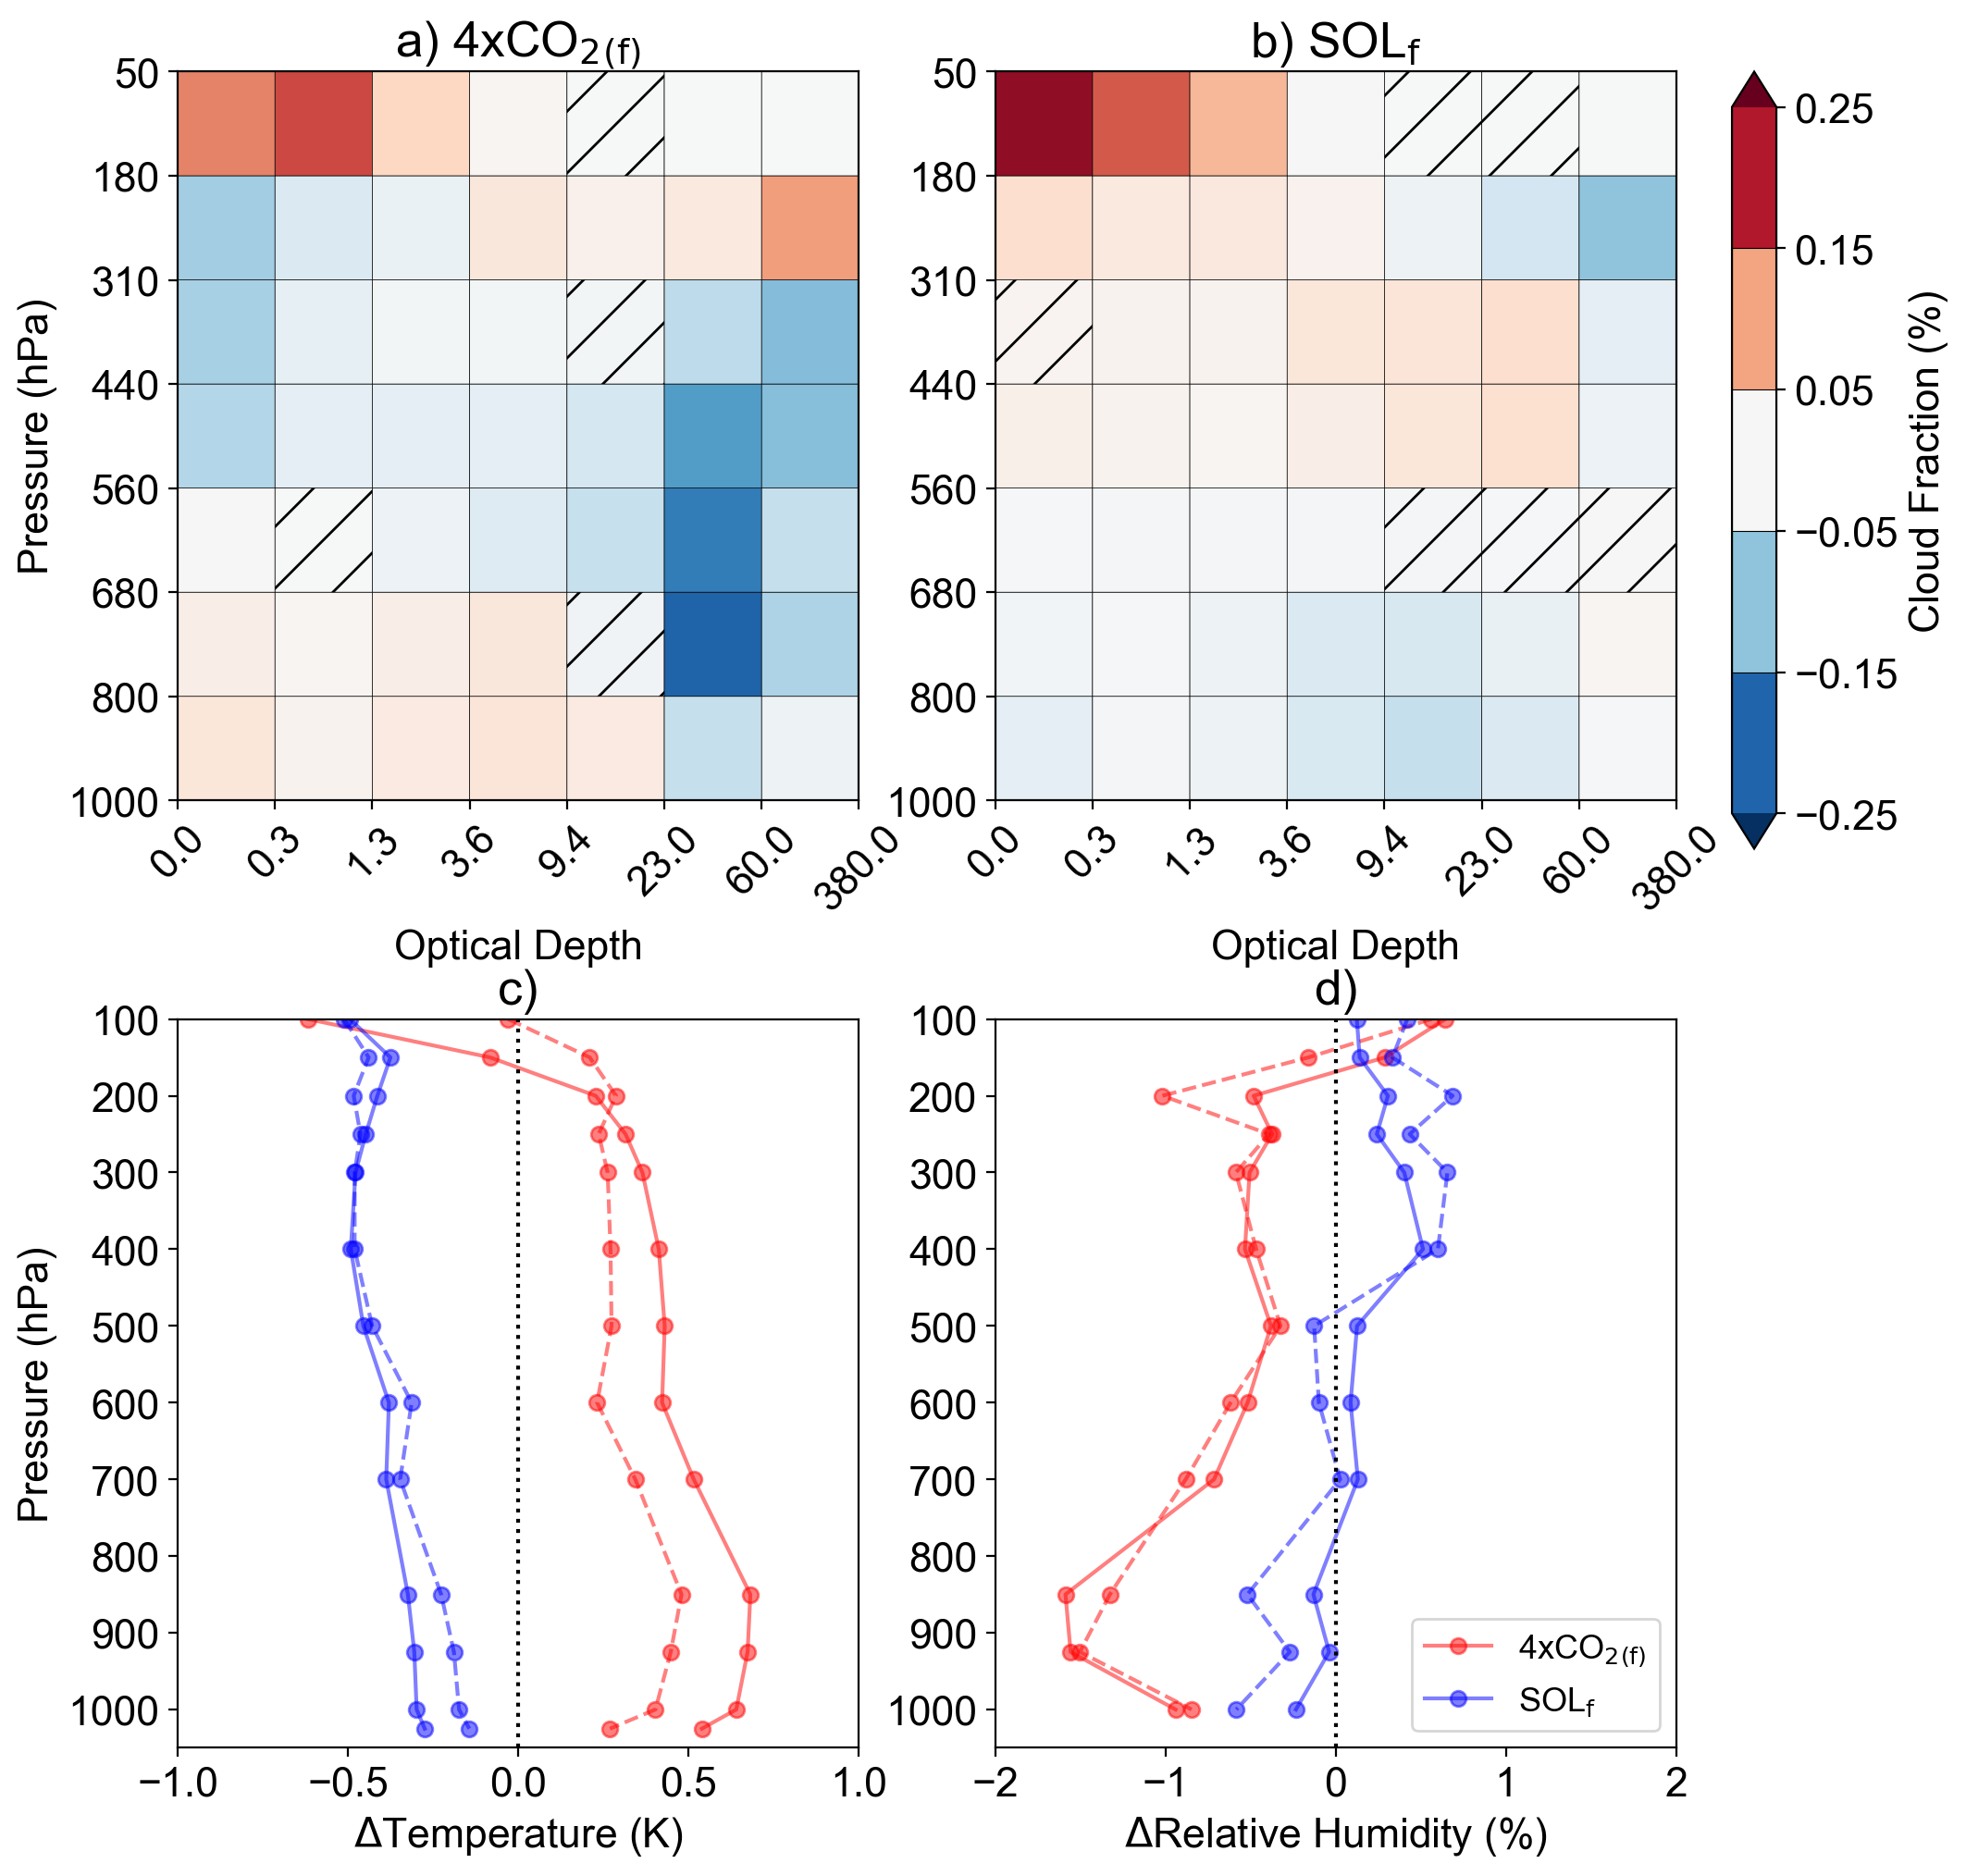

In [27]:
fig = plt.figure(figsize=(12,12),dpi=200)

plt.subplot(221)
plt.title('a) 4xCO$_{2}$$_{\mathrm{(f)}}$')
plt.pcolor(dgm['x4'],cmap=plt.cm.RdBu_r,vmin=-0.25,vmax=0.251,edgecolors='k')
plt.pcolor(np.ma.masked_less(binary['x4'],1),alpha=0,hatch='/')
plt.xticks(np.arange(8), tau,rotation=45)
plt.yticks(np.arange(8), ctp)
plt.xlabel('Optical Depth')
plt.ylabel('Pressure (hPa)')

plt.subplot(222)
plt.title('b) SOL$_{\mathrm{f}}$')
plt.pcolor(dgm['sol'],cmap=plt.cm.RdBu_r,vmin=-0.25,vmax=0.251,edgecolors='k')
plt.pcolor(np.ma.masked_less(binary['sol'],1),alpha=0,hatch='/')
plt.xticks(np.arange(8), tau,rotation=45)
plt.yticks(np.arange(8), ctp)
plt.xlabel('Optical Depth')

plt.subplots_adjust(hspace = 0.3,right=0.8)
cbar_ax = fig.add_axes([0.825, 0.53, 0.02, 0.35])
fig.colorbar(hist_spread, cax=cbar_ax,drawedges=True,label='Cloud Fraction (%)', orientation='vertical')

plt.subplot(223)
plt.title('c)')
plt.plot(append_glob['x4'][5:],cmip_plevs[5:],'-o',alpha=0.5,color='red')
plt.plot(append_trop['x4'][5:],cmip_plevs[5:],'-o',alpha=0.5,color='red',linestyle='--')
plt.plot(append_glob['sol'][5:],cmip_plevs[5:],'-o',alpha=0.5,color='blue')
plt.plot(append_trop['sol'][5:],cmip_plevs[5:],'-o',alpha=0.5,color='blue',linestyle='--')
plt.xlim(-1,1)
plt.xticks(np.arange(-1,1.1,0.5))
plt.ylim(100,1050)
plt.yticks(np.arange(100,1001,100))
plt.axvline(0,color='k',linestyle=':')
plt.ylabel('Pressure (hPa)')
plt.xlabel('$\Delta$Temperature (K)')
plt.gca().invert_yaxis()

plt.subplot(224)
plt.title('d)')
plt.plot(delta_glob['x4']['rh'][5:],cmip_plevs[5:-1],'-o',alpha=0.5,color='red', label = '4xCO$_{2}$$_{\mathrm{(f)}}$')
plt.plot(delta_trop['x4']['rh'][5:],cmip_plevs[5:-1],'-o',alpha=0.5,color='red', linestyle='--')
plt.plot(delta_glob['sol']['rh'][5:],cmip_plevs[5:-1],'-o',alpha=0.5,color='blue', label='SOL$_{\mathrm{f}}$')
plt.plot(delta_trop['sol']['rh'][5:],cmip_plevs[5:-1],'-o',alpha=0.5,color='blue', linestyle='--')
plt.xlim(-2,2)
plt.xticks(np.arange(-2,2.01,1))
plt.ylim(100,1050)
plt.yticks(np.arange(100,1001,100))
plt.axvline(0,color='k',linestyle=':')
plt.xlabel('$\Delta$Relative Humidity (%)')
plt.gca().invert_yaxis()
plt.legend(fontsize=13)

#plt.subplot(133)
#plt.plot(dcld_glob['x4'][:6],ctp[:6],'-o',alpha=0.5,color='red')
#plt.plot(dcld_glob['sol'][:6],ctp[:6],'-o',alpha=0.5,color='blue')
#plt.xlim(-1.0,1.01)
#plt.xticks(np.arange(-1.0,1.01,0.5))
#plt.ylim(100,1050)
#plt.yticks(np.arange(100,1001,100))
#plt.axvline(0,color='k',linestyle=':')
#plt.gca().invert_yaxis()

plt.savefig('TRH_profile.png',bbox_inches='tight')